In [1]:
# Linkamos con nuestro Drive para tener disponibles los archivos:
from google.colab import drive
drive.mount('/content/drive/')

# Se instala keras:
!pip install -q keras

Mounted at /content/drive/


In [2]:
# Cargamos librerías a usar
import keras

import matplotlib.pyplot as plt
import csv
import cv2
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator # Para hacer Data Augmentation
import shutil # Para copiar a otra carpeta
import copy
from pathlib import Path # Para crear directorios y saber elementos de una carpeta

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [49]:
# Funciones de preprocesado:
def image_preproc(img, coef = None, width = None, height = None, inter = cv2.INTER_AREA):
    dim = (width,height)
    # RGB to Gray image conversion
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # resize the image
    img_prep = cv2.resize(gray, dim, interpolation = inter)
    # rescale the image
    img_prep.astype('float32') # Convierte a float32
    img_prep = img_prep/coef # Escalado
    # return the resized image
    return img_prep

# Funciones de resultados:
def signal_type(prediction):
  # Vector con los nombres de las señales:
  signal = np.array(["Velocidad máxima 20 Km/h", "Velocidad máxima 30 Km/h", "Velocidad máxima 50 Km/h", "Velocidad máxima 60 Km/h", "Velocidad máxima 70 Km/h",
            "Fin de limitación de velocidad máxima 80 Km/h", "Velocidad máxima 90 Km/h", "Velocidad máxima 100 Km/h", "Velocidad máxima 120 Km/h", "Adelantamiento prohibido",
            "Adelantamiento prohibido para camiones", "Intersección con prioridad", "Calzada con prioridad", "Ceda el paso", "STOP", "Circulación prohibida en ambos sentidos",
            "Prohibición de acceso a vehículos destinados a transporte de mercancías", "Entrada prohibida", "Otros peligros", "Curva peligrosa hacia la izquierda",
            "Curva peligrosa hacia la derecha", "Curvas peligrosas hacia la izquierda", "Perfil irregular", "Pavimento deslizante", "Estrechamiento de calzada por la derecha",
            "Obras", "Semáforo", "Peatones", "Niños", "Ciclistas", "Pavimento deslizante por hielo o nieve", "Paso de animales en libertad", "Fin de prohibiciones",
            "Sentido obligatorio derecha", "Sentido obligatorio izquierda", "Sentido obligatorio recto", "Recto y derecha únicas direcciones permitidas",
            "Recto e izquierda únicas direcciones permitidas", "Paso obligatorio derecha", "Paso obligatorio izquierda", "Intersección de sentido giratorio-obligatorio",
            "Fin de prohibición de adelantamiento", "Fin de prohibición de adelantamiento para camiones"])
  # Se asocia el número obtenido en la predicción con el nombre de la señal:
  if len(prediction) > 0:
    for k in range(0,len(prediction)):
      if prediction[k] < 10:
        print(str(prediction[k]) + "   ==>  " + str(signal[prediction[k]]))
      else:
        print(str(prediction[k]) + "  ==>  " + str(signal[prediction[k]]))
  else:
    print(str(prediction) + "  ==>  " + str(signal[prediciton]))
  

In [4]:
# Cargamos el dataset, tanto imágenes como sus etiquetas:
# Versión 2: se aumentó el número de las de validation a partir del train
test_lab = np.load('/content/drive/My Drive/matrix_dataset_v2/backup_label_test.npy', allow_pickle=True)
test_im = np.load('/content/drive/My Drive/matrix_dataset_v2/backup_test.npy', allow_pickle=True)

# Carga el modelo con los pesos de la red:
from keras import layers
from keras import models

# cargar json y crear el modelo
# Nombre del archivo:
nombre = "/content/drive/My Drive/Modelos/Tr_99_55%_Val_99_86%_Te_98_51%_Adam_200epoch_200batch"

json_file = open(nombre + ".json", 'r')
model_json = json_file.read()
json_file.close()
model = models.model_from_json(model_json)

# cargar pesos al nuevo modelo
model.load_weights(nombre + ".h5")
print("Cargado modelo desde disco.")
model.summary() # Para ver como es la red

Cargado modelo desde disco.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_Layer (Conv2D)         (None, 62, 62, 32)        320       
_________________________________________________________________
Pooling1_Layer (MaxPooling2D (None, 31, 31, 32)        0         
_________________________________________________________________
Dropout1_CNN_Layer (Dropout) (None, 31, 31, 32)        0         
_________________________________________________________________
Conv2_Layer (Conv2D)         (None, 30, 30, 64)        8256      
_________________________________________________________________
Pooling2_Layer (MaxPooling2D (None, 15, 15, 64)        0         
_________________________________________________________________
Dropout2_CNN_Layer (Dropout) (None, 15, 15, 64)        0         
_________________________________________________________________
Conv3_Layer (Conv2D)      

In [5]:
print("Numero de imágenes: ", len(test_im))

Numero de imágenes:  12569


Tiempo empleado: 0.0366873741 seconds.
Las predicciones son: 
[[4.1205141e-14 1.0000000e+00 8.0112765e-12 9.8743411e-23 7.2472409e-16
  1.1419829e-16 1.7384860e-34 7.8632048e-16 4.2209827e-21 0.0000000e+00
  0.0000000e+00 5.6781769e-36 1.1841484e-33 9.4666245e-37 0.0000000e+00
  0.0000000e+00 3.4350094e-31 0.0000000e+00 9.7621454e-35 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 7.4334101e-31 0.0000000e+00
  1.4387696e-38 0.0000000e+00 2.6200708e-34 3.6584136e-26 0.0000000e+00
  6.3203183e-29 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.1476532e-28 0.0000000e+00 0.0000000e+00]]
La señal predicha es de la clase: 
[1]   ==>  ['Velocidad máxima 30 Km/h']
La señal pertence realmente a la clase: 
1   ==>  Velocidad máxima 30 Km/h


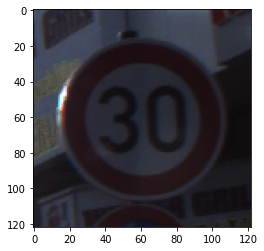

In [50]:
# Prueba con una imagen:
from time import time

# Elige la imagen:
num = 100
real_label = []
pred = []
# Le llega una imagen:
signal = copy.copy(test_im[num])
# Empieza el proceso:
start_time = time() # Tiempo de ejecución comienza

# Preprocesado:
ancho = 64
alto = 64
signal_prep = image_preproc(signal, coef = 255, width = ancho, height = alto)
test = signal_prep.reshape([-1,ancho, alto,1])
#test = np.expand_dims(signal_prep, axis=0)
# Clasificación:
predictions = model.predict(test, batch_size=1, verbose=0) # Obtiene los 43 porcentajes para la imagen
pred_max = np.argmax(predictions, axis=-1) # Se queda con la que tiene mayor porcentaje

# Termina el proceso:
elapsed_time = time() - start_time # Tiempo de ejecución termina
print("Tiempo empleado: %.10f seconds." % elapsed_time) # Imprime el tiempo que ha tardado
pred.append(pred_max)
real_label.append(int(test_lab[num]))


# Imprime la clase predicha y la imagen original:
print("Las predicciones son: ")
print(predictions)
print("La señal predicha es de la clase: ")
signal_type(pred)
print("La señal pertence realmente a la clase: ")
signal_type(real_label)
plt.imshow(signal)

In [51]:
# Prueba con varias imágenes para hacer una media del tiempo que suele tardar:
from time import time
from random import randint

# Elige la imagen:
numero_imagenes = 10
real_label = []
elapsed = []
pred = []
for k in range(0,numero_imagenes):
  # Le llega una imagen:
  num = randint(0,len(test_lab)-1) # Número aleatorio entre 0 y el número de imágenes - 1
  signal = copy.copy(test_im[num])
  # Empieza el proceso:
  start_time = time() # Tiempo de ejecución comienza

  # Preprocesado:
  ancho = 64
  alto = 64
  signal_prep = image_preproc(signal, coef = 255, width = ancho, height = alto)
  test = signal_prep.reshape([-1,ancho, alto,1])
  #test = np.expand_dims(signal_prep, axis=0)
  # Clasificación:
  predictions = model.predict(test, batch_size=1, verbose=0) # Obtiene los 43 porcentajes para la imagen
  pred_max = np.argmax(predictions, axis=-1) # Se queda con la que tiene mayor porcentaje
  # Termina el proceso:
  elapsed_time = time() - start_time # Tiempo de ejecución 
  
  pred.append(pred_max)
  elapsed.append(elapsed_time)
  real_label.append(int(test_lab[num]))
  print("Tiempo empleado: %.10f seconds." % elapsed_time) # Imprime el tiempo que ha tardado

# Imprime la clase predicha y la imagen original:
print("Tiempo medio que tarda en segundos: ", sum(elapsed)/numero_imagenes)
print("La señal predicha es de la clase: ")
signal_type(pred)
print("La señal pertence realmente a la clase: ")
signal_type(real_label)
#plt.imshow(signal)

Tiempo empleado: 0.0405769348 seconds.
Tiempo empleado: 0.0355205536 seconds.
Tiempo empleado: 0.0332803726 seconds.
Tiempo empleado: 0.0340883732 seconds.
Tiempo empleado: 0.0338485241 seconds.
Tiempo empleado: 0.0338528156 seconds.
Tiempo empleado: 0.0367755890 seconds.
Tiempo empleado: 0.0347564220 seconds.
Tiempo empleado: 0.0576369762 seconds.
Tiempo empleado: 0.0471534729 seconds.
Tiempo medio que tarda en segundos:  0.03874900341033936
La señal predicha es de la clase: 
[11]  ==>  ['Intersección con prioridad']
[30]  ==>  ['Pavimento deslizante por hielo o nieve']
[13]  ==>  ['Ceda el paso']
[5]   ==>  ['Fin de limitación de velocidad máxima 80 Km/h']
[28]  ==>  ['Niños']
[12]  ==>  ['Calzada con prioridad']
[9]   ==>  ['Adelantamiento prohibido']
[4]   ==>  ['Velocidad máxima 70 Km/h']
[12]  ==>  ['Calzada con prioridad']
[5]   ==>  ['Fin de limitación de velocidad máxima 80 Km/h']
La señal pertence realmente a la clase: 
11  ==>  Intersección con prioridad
30  ==>  Pavimento d